In [1]:
#Loading Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data partition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler


# embedded methods
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score



# Step 1: Importing and Exploring the Dataset
## Describe and recompute variables

In [2]:
#Getting Data
import pyreadstat
df, meta = pyreadstat.read_sas7bdat('a2z_insurance.sas7bdat')

df.head()
#df.set_index("CustID", inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustID         10296 non-null  float64
 1   FirstPolYear   10266 non-null  float64
 2   BirthYear      10279 non-null  float64
 3   EducDeg        10296 non-null  object 
 4   MonthSal       10260 non-null  float64
 5   GeoLivArea     10295 non-null  float64
 6   Children       10275 non-null  float64
 7   CustMonVal     10296 non-null  float64
 8   ClaimsRate     10296 non-null  float64
 9   PremMotor      10262 non-null  float64
 10  PremHousehold  10296 non-null  float64
 11  PremHealth     10253 non-null  float64
 12  PremLife       10192 non-null  float64
 13  PremWork       10210 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [3]:
#Get an overview over all numeric variables
#max value First pol year seems odd

df.describe(include=None).T

,count,mean,std,min,25%,50%,75%,max
CustID,10296.0,5148.500000,2972.343520,1.00,2574.75,5148.50,7722.2500,10296.00
FirstPolYear,10266.0,1991.062634,511.267913,1974.00,1980.00,1986.00,1992.0000,53784.00
BirthYear,10279.0,1968.007783,19.709476,1028.00,1953.00,1968.00,1983.0000,2001.00
MonthSal,10260.0,2506.667057,1157.449634,333.00,1706.00,2501.50,3290.2500,55215.00
GeoLivArea,10295.0,2.709859,1.266291,1.00,1.00,3.00,4.0000,4.00
Children,10275.0,0.706764,0.455268,0.00,0.00,1.00,1.0000,1.00
CustMonVal,10296.0,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89
ClaimsRate,10296.0,0.742772,2.916964,0.00,0.39,0.72,0.9800,256.20
PremMotor,10262.0,300.470252,211.914997,-4.11,190.59,298.61,408.3000,11604.42
PremHousehold,10296.0,210.431192,352.595984,-75.00,49.45,132.80,290.0500,25048.80


In [4]:
#All non numerc variables
df.describe(include="object") 
print(df.EducDeg.unique())

['2 - High School' '1 - Basic' '3 - BSc/MSc' '4 - PhD' '']


In [5]:
#rewrite education to make it a numerical variable

education_encoded = {"4 - PhD":4, 
                    "3 - BSc/MSc":3,
                    "1 - Basic":1, 
                    "2 - High School":2}

df["Education_Level"]=df["EducDeg"].map(education_encoded)

#Drop old variable
df = df.drop('EducDeg',axis = 1)

df["Education_Level"].unique()

array([ 2.,  1.,  3.,  4., nan])

# Step 2: Identify and replace Null Values
## KNN Imputer

In [6]:
#Check for NaNs
#The Dataset has a lot of null values in various dimensions

df[df.isnull().any(axis=1)].shape[0]
#Overall 309 rows with NA values -> 3% of the Dataset
print("Null values as percent of dataset", (df[df.isnull().any(axis=1)].shape[0]/df.shape[0]))
print(df.isnull().sum())

#We impute the values after 

Null values as percent of dataset 0.030011655011655012
CustID               0
FirstPolYear        30
BirthYear           17
MonthSal            36
GeoLivArea           1
Children            21
CustMonVal           0
ClaimsRate           0
PremMotor           34
PremHousehold        0
PremHealth          43
PremLife           104
PremWork            86
Education_Level     17
dtype: int64


In [7]:
#we utilize the KNN Imputer in order to fill the Null values
from sklearn.impute import KNNImputer
fill_NaN = KNNImputer(missing_values=np.nan)
imputed_DF = pd.DataFrame(fill_NaN.fit_transform(df))
imputed_DF.columns = df.columns
imputed_DF.index = df.index
df=imputed_DF
print(df.isnull().sum())

CustID             0
FirstPolYear       0
BirthYear          0
MonthSal           0
GeoLivArea         0
Children           0
CustMonVal         0
ClaimsRate         0
PremMotor          0
PremHousehold      0
PremHealth         0
PremLife           0
PremWork           0
Education_Level    0
dtype: int64


# Data Inconstencies

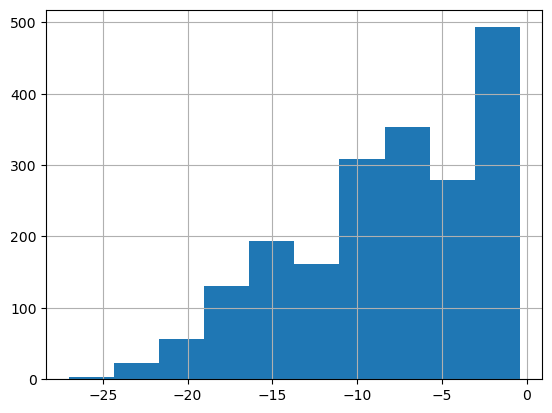

In [8]:
#Rows where the Birth year is lower than the first Pol Year
#Well what about those??
by_wrong=df[df["FirstPolYear"]<df["BirthYear"]]

(by_wrong["FirstPolYear"]-by_wrong["BirthYear"]).hist()
plt.show()

### Inconsistency Hyopthesis: there could be values in "Birth Year" which are bigger than 2016. Not the case but there are a few observations which are underage -> possible

In [9]:
df["BirthYear"]
(2016-df["BirthYear"]).value_counts().sort_index()
#nothing bigger than 2016 but a few outliers

15.0      12
16.0      35
17.0      69
18.0      94
19.0     133
        ... 
78.0      77
79.0      57
80.0      37
81.0      14
988.0      1
Name: BirthYear, Length: 81, dtype: int64

### Inconsistency Hyopthesis: there could be values in "First Pol Year" which are bigger than 2016. True for one Case -> will be deleted

In [10]:
print((2016-df["FirstPolYear"]).value_counts().sort_index())
df=df.drop(df[2016-df["FirstPolYear"]<0].index, axis = 0)

-51768.0      1
 18.0       112
 19.0       271
 20.0       440
 21.0       445
 22.0       475
 23.0       473
 24.0       451
 25.0       430
 26.0       449
 26.6         1
 26.8         2
 27.0       467
 27.2         1
 27.4         1
 28.0       512
 28.4         2
 28.6         1
 29.0       440
 29.4         3
 29.6         1
 30.0       458
 30.2         1
 30.4         2
 30.6         1
 30.8         1
 31.0       430
 31.8         1
 32.0       466
 33.0       423
 33.8         1
 34.0       446
 34.4         2
 35.0       445
 35.4         1
 36.0       432
 37.0       443
 38.0       453
 39.0       453
 40.0       433
 41.0       285
 42.0       141
Name: FirstPolYear, dtype: int64


## Identification and Treatment of outliers

In [11]:
#Creating a function to get the columns which contain outliers

def outlier_cols(dafra):
    num_col=list(dafra.select_dtypes(include=np.number).columns)
    res = []
    for x in num_col:
        q75,q25 = np.percentile(dafra.loc[:,x],[75,25])
        intr_qr = q75-q25

        max = q75+(1.5*intr_qr)
        min = q25-(1.5*intr_qr)

        if dafra.loc[dafra[x] < min,x].empty == False or dafra.loc[dafra[x] > max,x].empty == False:
            res.append(x)
            
    f, axes = plt.subplots((len(res)+1)//2, 2, figsize=(15,8), constrained_layout=True)  
    y = 0;
    for name in res:
        i, j = divmod(y, 2)
        sns.boxplot(x=dafra[name], ax=axes[i, j])
        y = y + 1
    plt.show()
    
    return res


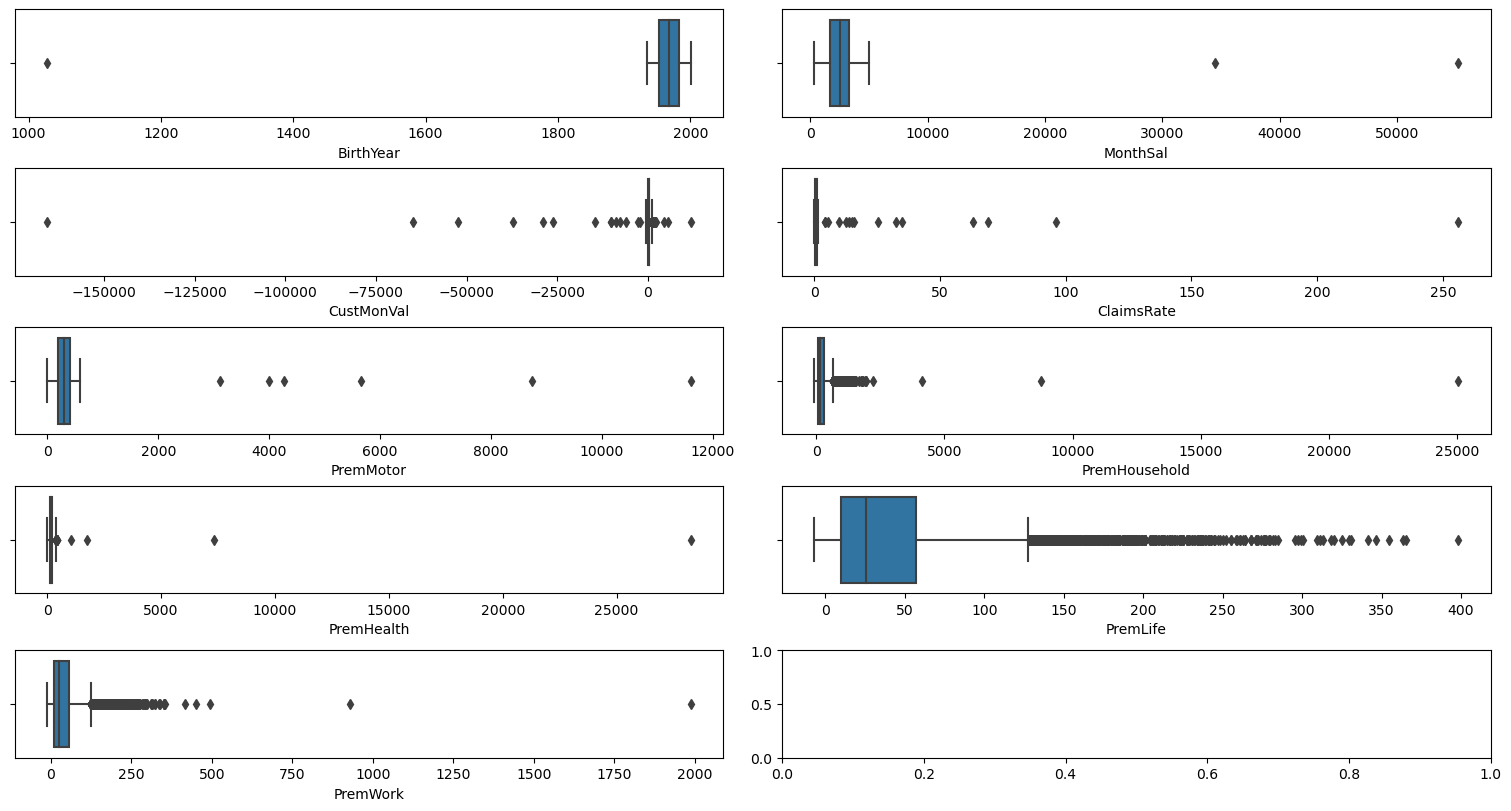

In [12]:
out_col=outlier_cols(df)

## Outliers: Birth Year

7195    1028.0
1013    1935.0
958     1935.0
8422    1935.0
7440    1935.0
         ...  
1436    2001.0
3146    2001.0
9906    2001.0
659     2001.0
5347    2001.0
Name: BirthYear, Length: 10295, dtype: float64


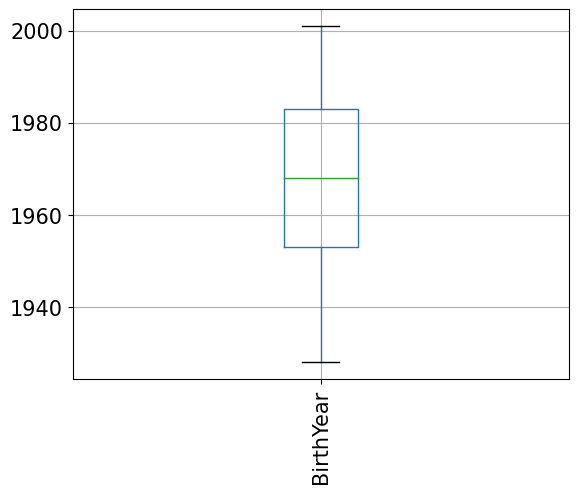

In [13]:
#Assumption: the low values in Birth Year have been typos
print(df["BirthYear"].sort_values())
df["BirthYear"]=[i+900 if i<1900 else i for i in df["BirthYear"]]
df.boxplot("BirthYear",rot=90, fontsize=15)
plt.show()

## Outliers: MonthSal

In [14]:
#Assumption: A monthly salary like that is possible
#We have to check if it affects the clustering and remove or cap them if it does
df["MonthSal"].sort_values()

4035      333.0
4881      333.0
4275      333.0
6846      334.0
2260      335.0
         ...   
4440     4904.0
4244     4995.0
7510     5021.0
8261    34490.0
5882    55215.0
Name: MonthSal, Length: 10295, dtype: float64

## Outliers: ClaimsRate

In [15]:
def outlier_subset (dataframe, col):
    final=pd.DataFrame()
    for i in col:
        q25 = dataframe[i].quantile(.25)
        q75 = dataframe[i].quantile(.75)
        iqr = (q75 - q25)

        upper_lim = q75 + 1.5 * iqr
        lower_lim = q25 - 1.5 * iqr

        res = dataframe[(dataframe[i]>upper_lim) | (dataframe[i]<lower_lim)]
        final=pd.concat([final, res])
    return final

Null values as percent of dataset 0.1457017969888295 %


<AxesSubplot:>

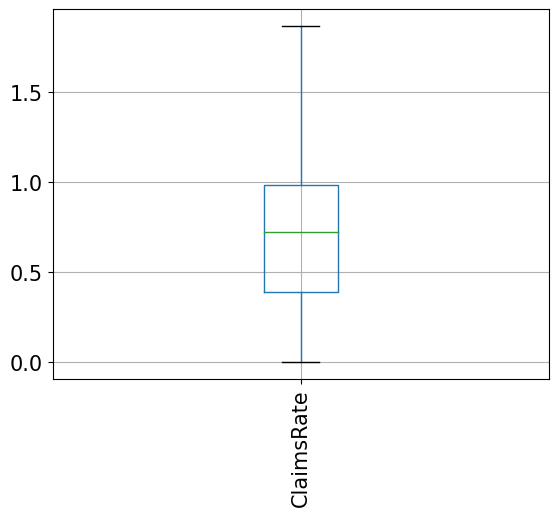

In [16]:
#Question 1: Are the outliers possible at all or false data?
#Question 2: Are the values coherent with the other data

#Claims Rate: Amount paid by the insurance company (€)/ Premiums (€) Note: in the last 2 years
#A high claims rate means that the insurance had to pay way more than it earned on these customers in the last two years

#Get a subset of the outliers: 
cl_rate_out=outlier_subset(df, ["ClaimsRate"])

print("Null values as percent of dataset", ((cl_rate_out.shape[0]/df.shape[0])*100), "%")
#since not many values are lost, 1,4% we first try to floor/cap them 
#if they still have high influence on the clustering we drop them

def floor_cap(dataframe, out_col):
    for i in out_col:
            Q1 = dataframe[i].quantile(0.25)
            Q3 = dataframe[i].quantile(0.75)
            IQR = Q3 - Q1
            whisker_width = 1.5
            lower_whisker = Q1 -(whisker_width*IQR)
            upper_whisker = Q3 + (whisker_width*IQR)
            dataframe[i]=np.where(dataframe[i]>upper_whisker,upper_whisker,np.where(dataframe[i]<lower_whisker,lower_whisker,dataframe[i]))
            return dataframe
            
df=floor_cap(df, ["ClaimsRate"])
df.boxplot("ClaimsRate",rot=90, fontsize=15)

# Outliers: Prem Motor

Number of outliers as percent of dataset 0.058280718795531816 %


<AxesSubplot:>

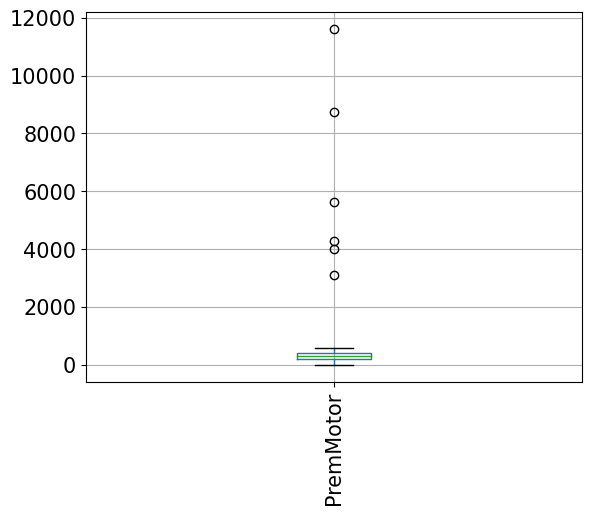

In [21]:

prem_mot_out=outlier_subset(df, ["PremMotor"])

print("Number of outliers as percent of dataset", ((prem_mot_out.shape[0]/df.shape[0])*100), "%")

            
#df=floor_cap(df, ["ClaimsRate"])
df.boxplot("PremMotor",rot=90, fontsize=15)

In [23]:
#df.boxplot("CustMonVal",rot=90, fontsize=15)
#plt.show()

def outlier_subset (dataframe, col):
    final=pd.DataFrame()
    for i in col:
        q25 = dataframe[i].quantile(.25)
        q75 = dataframe[i].quantile(.75)
        iqr = (q75 - q25)

        upper_lim = q75 + 1.5 * iqr
        lower_lim = q25 - 1.5 * iqr

        res = dataframe[(dataframe[i]>upper_lim) | (dataframe[i]<lower_lim)]
        final=pd.concat([final, res])
    return final
drops=outlier_subset(df, out_col)
drops=drops.index

df_clean=df.drop(drops)
df_clean

,CustID,FirstPolYear,BirthYear,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Education_Level
0,1.0,1985.0,1982.0,2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89,2.0
2,3.0,1991.0,1970.0,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02,1.0
3,4.0,1990.0,1981.0,1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,3.0
4,5.0,1986.0,1973.0,1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45,3.0
5,6.0,1986.0,1956.0,2566.0,4.0,1.0,-24.33,1.00,440.75,18.90,114.80,7.00,7.67,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10289,10290.0,1986.0,1943.0,3498.0,4.0,0.0,245.60,0.67,227.82,270.60,160.92,100.13,69.90,2.0
10291,10292.0,1984.0,1949.0,3188.0,2.0,0.0,-0.11,0.96,393.74,49.45,173.81,9.78,14.78,4.0
10293,10294.0,1994.0,1976.0,2918.0,1.0,1.0,524.10,0.21,403.63,132.80,142.25,12.67,4.89,3.0
10294,10295.0,1981.0,1977.0,1971.0,2.0,1.0,250.05,0.65,188.59,211.15,198.37,63.90,112.91,1.0


In [18]:
# df[df["FirstPolYear"]<df["BirthYear"]]

# df["neg_birth_year"] = df["FirstPolYear"]-df["BirthYear"]

# df['Test_Birth'] = np.where(df['neg_birth_year'] < 0, np.nan, df["BirthYear"])

# df_imp_test = df.copy()
# df_imp_test

# fill_NaN = KNNImputer(missing_values=np.nan)
# imputed_DF_b = pd.DataFrame(fill_NaN.fit_transform(df_imp_test))
# imputed_DF_b.columns = df_imp_test.columns
# imputed_DF_b.index = df_imp_test.index
# test_set=imputed_DF_b[df["FirstPolYear"]<df["BirthYear"]]

# (test_set["FirstPolYear"]-test_set["Test_Birth"]).hist()
# plt.show()

# print("Succesfully imputed", test_set[test_set["Test_Birth"]<test_set["FirstPolYear"]].count()[0])

# test_set["Test_Birth"].value_counts()

In [19]:
df_original = df.copy()

# Dimensionality Reduction: PCA
### Principal component analysis (PCA) is a popular technique for analyzing large datasets containing a high number of dimensions/features per observation, increasing the interpretability of data while preserving the maximum amount of information, and enabling the visualization of multidimensional data. Formally, PCA is a statistical technique for reducing the dimensionality of a dataset.

array([0.23717119, 0.40627747, 0.54848776, 0.62070074, 0.69251855,
       0.76353444, 0.83360615, 0.87949454, 0.9206324 ])

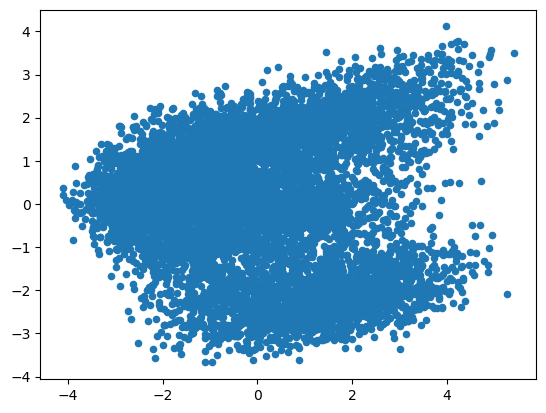

In [24]:
from sklearn.decomposition import PCA

#Data needs to be scaled for the pca to work properly
#data centration is done by the pca function within sklearn
df_scaled=StandardScaler().fit_transform(df_clean)

pca = PCA(n_components=0.9, random_state=2)
pca.fit(df_scaled)

df_pca=pca.transform(df_scaled)

df_pca.shape
round(float(pca.explained_variance_ratio_[0] * 100)) #variance explained by the first pca col
plt.scatter(df_pca[:, 0], df_pca[:, 1], s=20, cmap='viridis');

np.cumsum(pca.explained_variance_ratio_)

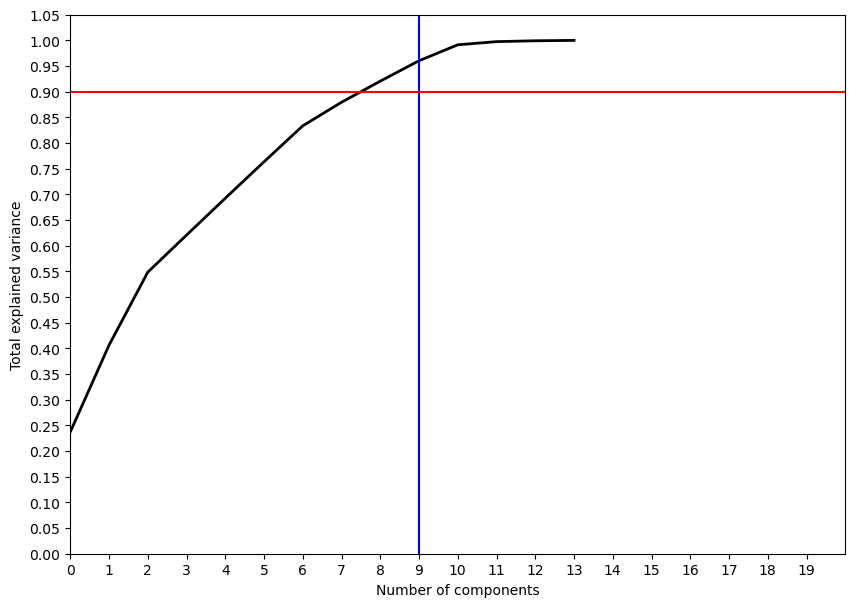

In [25]:
pca = PCA().fit(df_scaled)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 20)
plt.yticks(np.arange(0, 1.1, 0.05))
plt.xticks(np.arange(0, 20, 1))
plt.axvline(df_pca.shape[1], c='b')
plt.axhline(0.9, c='r')
plt.show();

# Kmeans Clustering

In [26]:
from sklearn.cluster import KMeans
#defining clusters
kmeans = KMeans(n_clusters= 3,  init='k-means++', 
                random_state=67)
kmeans.fit(df_pca)
cluster_labels = kmeans.labels_
cluster_labels.shape

(8798,)

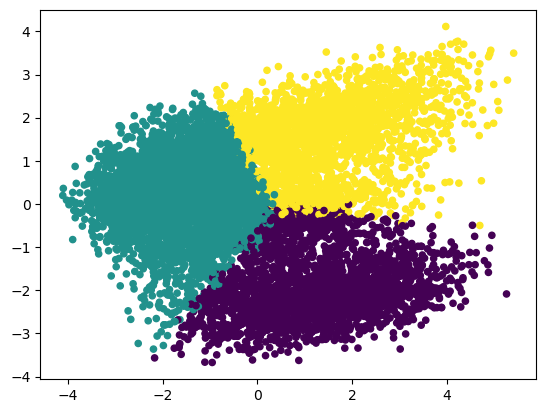

In [27]:
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=cluster_labels, s=20,  
            cmap='viridis');

In [ ]:
# #Add the cluster labels to the cleaned and unscaled dataframe
df_clean["kmeans_label"] = cluster_labels.tolist()
#look at the mean values per cluster to interpret them 
df_clean.groupby(["kmeans_label"]).mean()